In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import logging
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import gc
from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.signal import butter, sosfilt
from devito import *
from copy import deepcopy
from distributed import Client, wait, LocalCluster
from skimage.metrics import structural_similarity as ssim

from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver

from devito_ta.model_geom import get_model, get_geometry, grad_utils
from devito_ta.prepro import Filter, filter_data, CustomSource
from devito_ta.simulation_born_ms import fm_multi_shots, grad_multi_shots, born_multi_shots, normalize
from devito_ta.prepro_dl import train, prepare_data
from devito_ta.plotting import plot_shotrecord_cust, plot_velocity_cust, plot_acquisition_geometry, plot_freq
from deeplearning_ta.attention_r2_unet import *


configuration['log-level'] = 'WARNING'
configuration['opt'] = 'advanced'
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

In [4]:
file = 'vp_marmousi-ii_10m.segy'

with segyio.open(file, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:] 

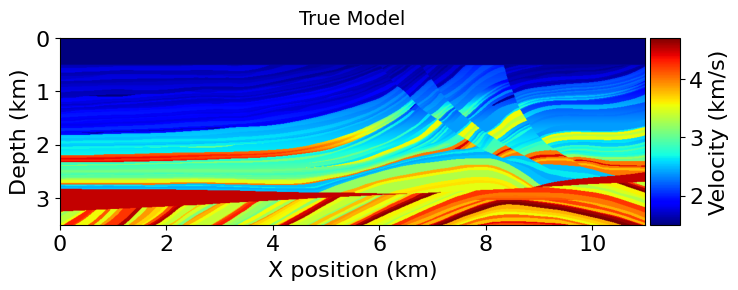

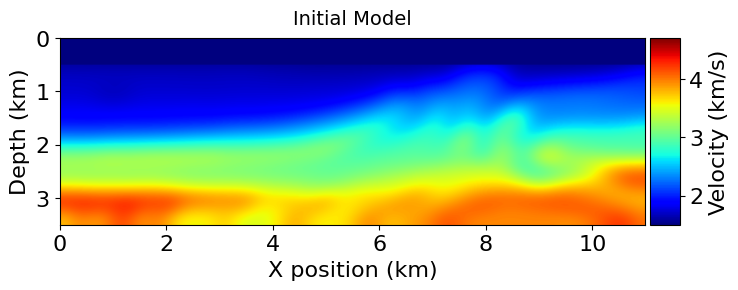

In [7]:
# Define water bottom depth in grid
wb = 50

# Define the model
v = data[200:1300, wb:].copy()             # Remove water layer

# Add water bottom to initial model
water_btm = np.ones((v.shape[0], wb)) * 1.5
v = np.concatenate([water_btm, v], axis=1)
minv = v.min()
maxv = v.max()

# Create initial model
init = gaussian_filter(v, sigma=[20, 20])  
init[:, :wb] = water_btm

init = np.clip(init, a_min=1.5, a_max=4.5)

# Get model

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

model1 = get_model(np.clip(v, 1.5, 5), shape, spacing, origin)
model0 = get_model(init, shape, spacing, origin)

# Plot velocity model
plot_velocity_cust(model1, colorbar=True, save=False, title='True Model', name='true_model')
plot_velocity_cust(model0, colorbar=True, save=False, title='Initial Model', name='init_model')


In [10]:
# Create new geometry for 50 shots
par = {'nx':1100,          'dx':10,       'ox':0,
       'nz':351,          'dz':10,       'oz':0,
       'ns':30,           'ds':300,      'os':2020.0,  'sz':0,
       'nr':200,          'dr':10.0,     'or':0,       'rz':0,
       'nt':4000,         'dt':1.18,        'ot':0,       'nof':20,
       'freq':10,
      }

# Sampling frequency
fs = 1 / (par['dt']/1000)
nbl = model1.nbl

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz'] 

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz'] 

geometry1 = get_geometry(model=model1,
                         src_x=x_s[:, 0],
                         src_z=x_s[:, 1],
                         rec_x=x_r[:, 0],
                         rec_z=x_r[:, 1],
                         t0=0,
                         tn=par['nt'],
                         nof=par['nof'],
                         src_type='Ricker',
                         f0=par['freq']/1000,
                         dt=par['dt'])

# Call Dask cluster for parallel computing
n_workers = 6

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit='auto',
    threads_per_worker=4,
    death_timeout=3600
)

client = Client(cluster)
client.restart()

/Users/dzianddafi/myenv/lib/python3.11/site-packages/distributed/deploy/spec.py:324: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54442 instead
  self.scheduler = cls(**self.scheduler_spec.get("options", {}))


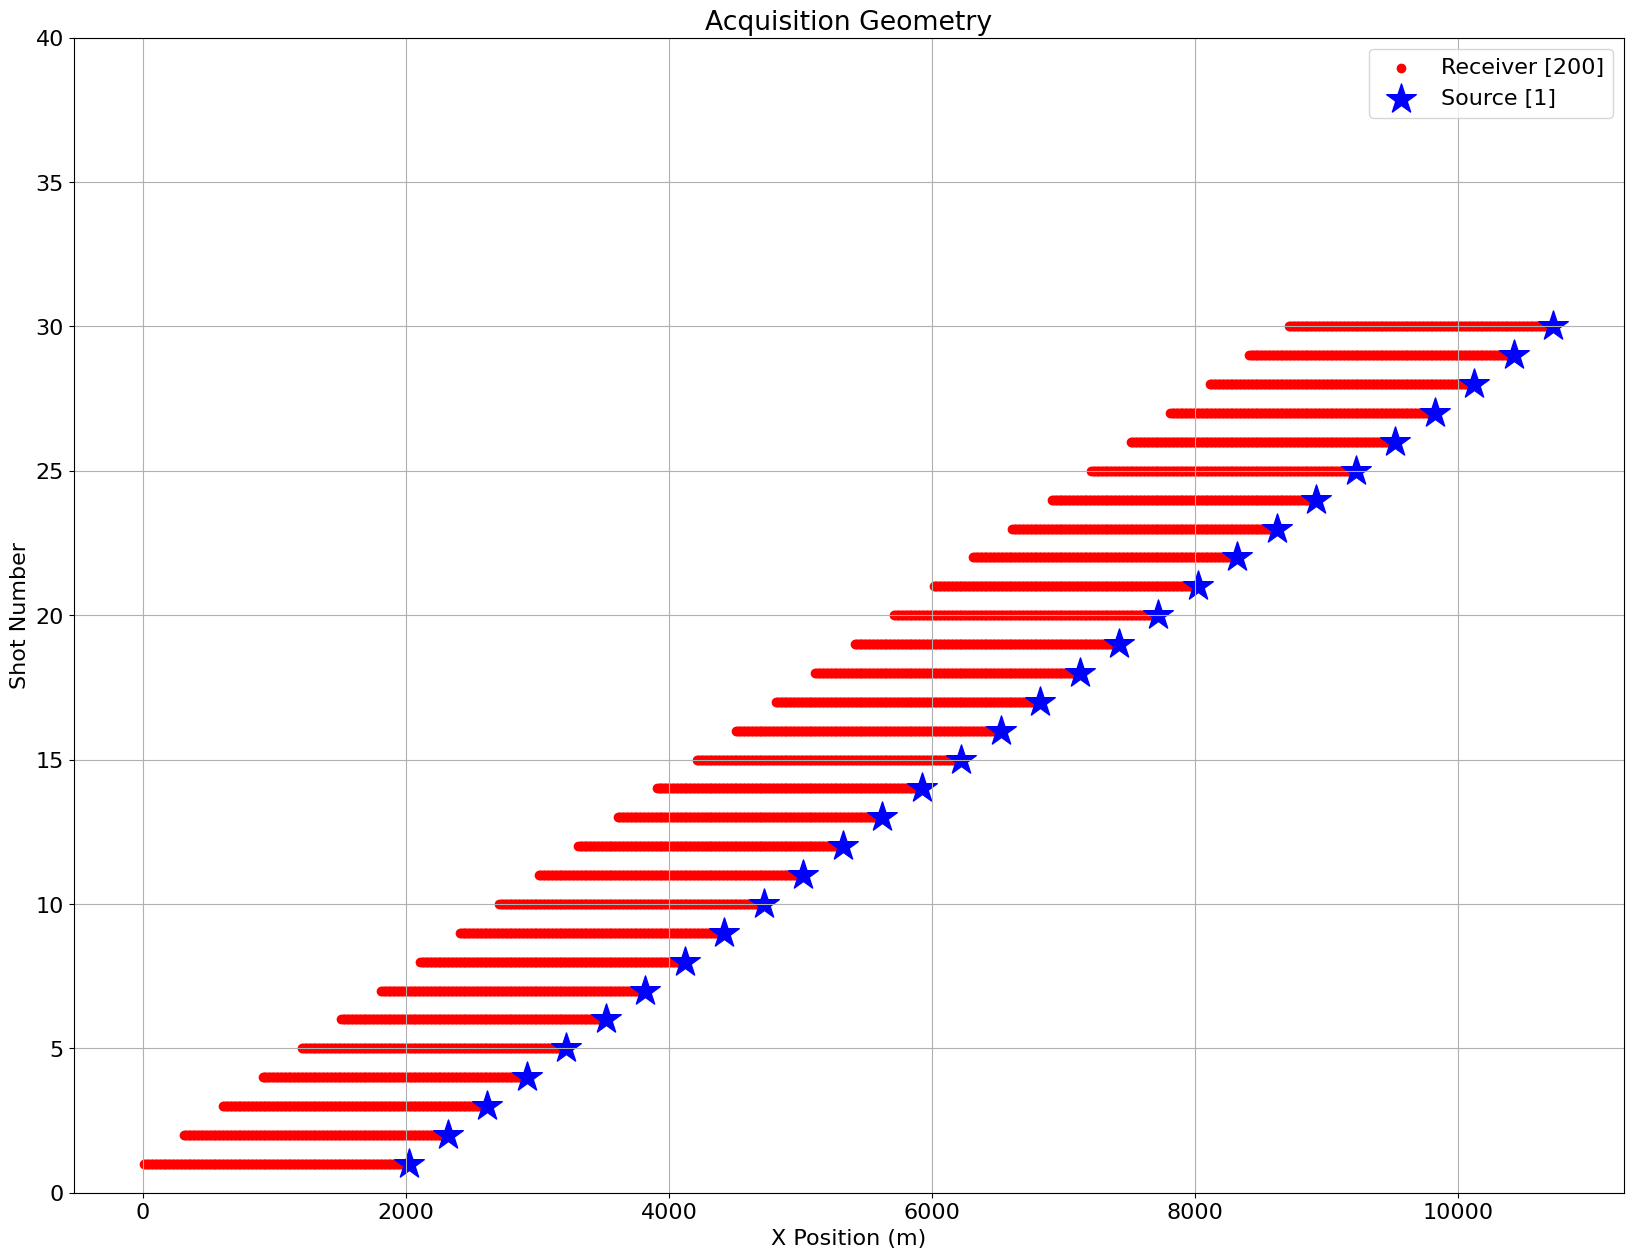

In [11]:
plot_acquisition_geometry(geometry1, 'Acquisition Geometry')

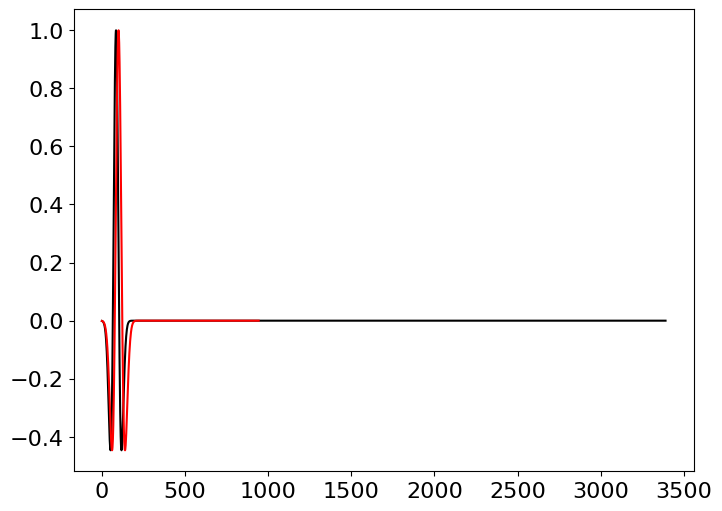

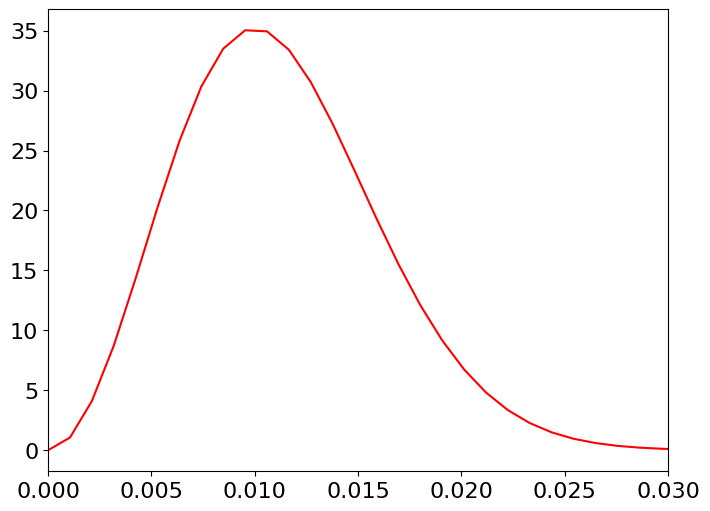

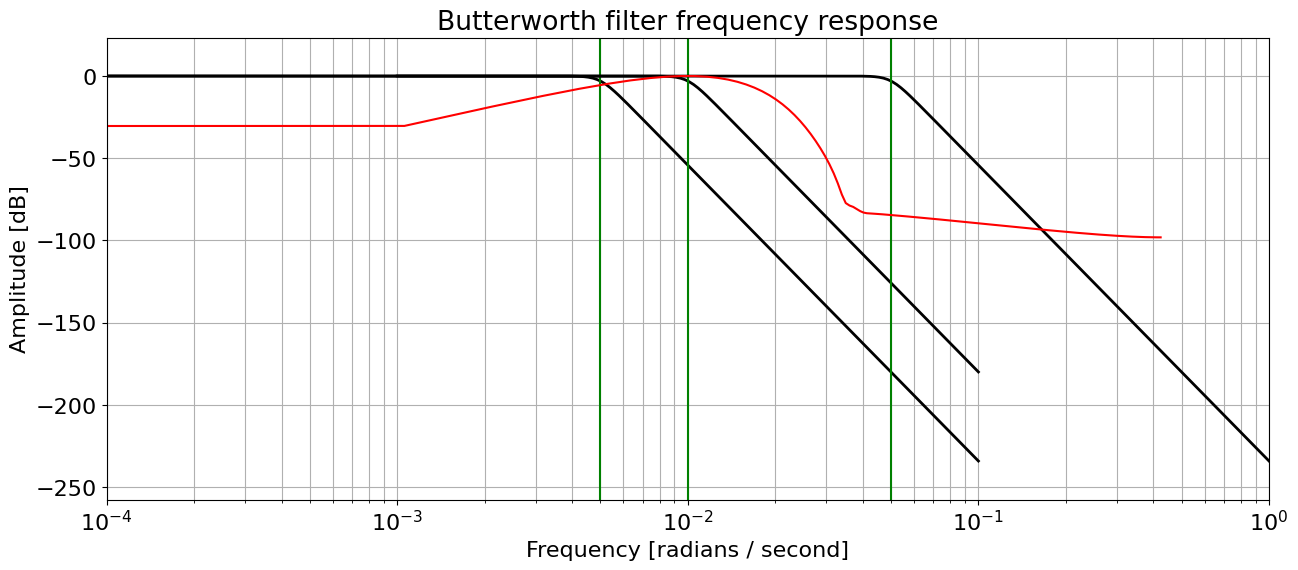

In [ ]:
# The filtering phase is highly inspired by
# https://github.com/mrava87/Devito-fwi/blob/main/notebooks/acoustic/AcousticVel_L2_Nstages.ipynb
# Analyze source wavelet
nwav = 800
wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000)

# Params (3stages)
frequencies = [0.005, 0.01, 0.05]
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]


# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)

# plot frequency response in dB
plt.semilogx(f, 20*np.log10(np.abs(WAV)/np.max(np.abs(WAV))) , 'r')

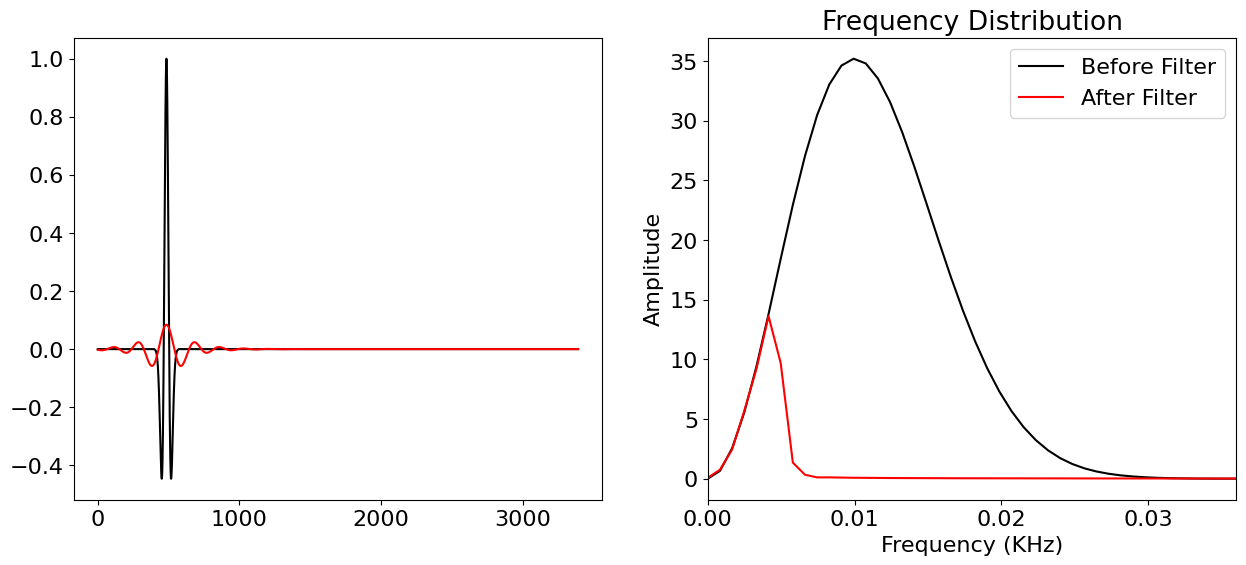

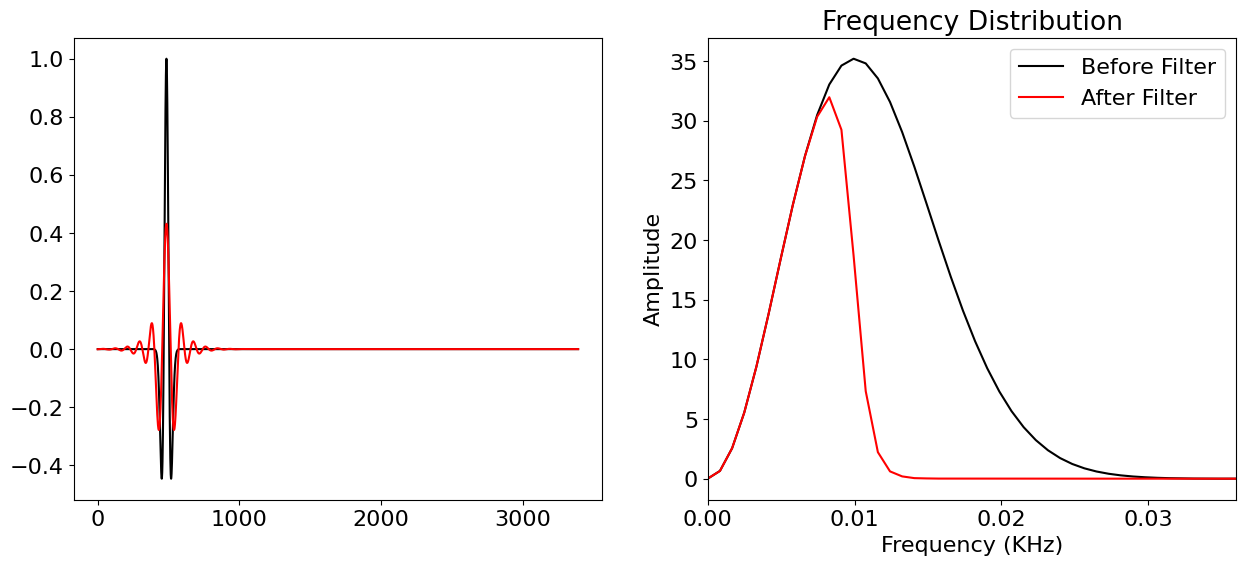

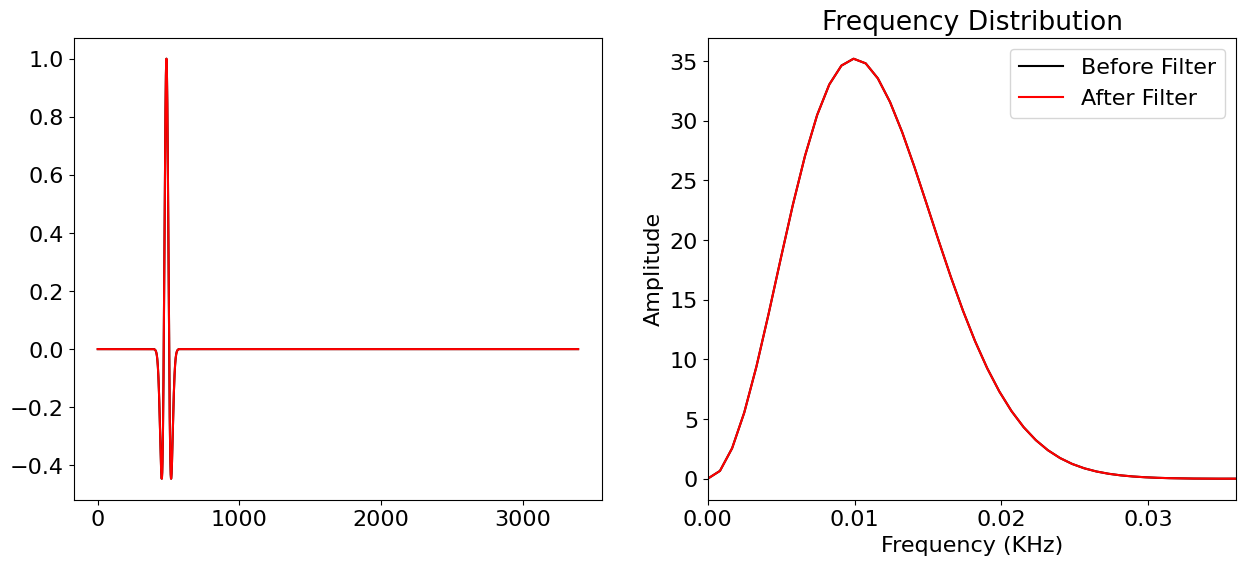

In [ ]:
# Apply filters and plot results
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].set_title('Frequency Distribution')
    axs[1].set_xlabel('Frequency (KHz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].plot(f, np.abs(WAV), 'k', label='Before Filter')
    axs[1].plot(f, np.abs(WAVfilt), 'r', label='After Filter')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3);
    plt.legend()
    

In [ ]:
# Perform forward modelling at 10 Hz
dt = par['dt']

start_10hz = time.time()
fm = fm_multi_shots(model1, geometry1, n_workers, client, dt=dt)
finish_10hz = time.time()

duration_10hz = finish_10hz - start_10hz
print(f'Forward modelling duration for 30 shots: {(duration_10hz/60):.2f} minutes')

In [ ]:
# Get observed data
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, f'Data at {geometry1[0].src_positions[0][0].item()} m',
                     dobs[14].data, f'Data at {geometry1[14].src_positions[0][0].item()} m',
                     dobs[-1].data, f'Data at {geometry1[-1].src_positions[0][0].item()} m',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

In [ ]:
# Filtering

# Params (3stages)
frequencies = [0.005, 0.01, 0.05] #in KHz
nfilts = [9, 9, 9]
ftol = [1e-10, 1e-10, 1e-10]
maxiter = [50, 50, 50]
maxfun = [200, 200, 200]
nwav = 800

wav = geometry1[1].src.wavelet

f = np.fft.rfftfreq(nwav, par['dt'])
WAV = np.fft.rfft(wav[:nwav], nwav)

# Plot original wavelet
plt.figure()
plt.plot(wav, c='k')
plt.plot(geometry1[1].time_axis.time_values[:nwav], wav[:nwav], c='r')

plt.figure()
plt.plot(f, np.abs(WAV), c='r')
plt.xlim(0, par['freq']*3/1000)

# Extract wavelet and pad it to allow filtering
wavpad = 400
wav = wav[:2*np.argmax(wav)+1]
wav = np.pad(wav, (wavpad, geometry1[0].nt - wavpad - wav.size))

# Define filter
nfft = 2**10

plt.figure(figsize=(15, 6))
Filt = Filter(frequencies, nfilts, par['dt'], plotflag=True)
plt.semilogx(f, 20*np.log10(np.abs(WAV)) - 28, 'r')

# Filter wavelet
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)
src = CustomSource(name='src', grid=model1.grid,
                               wav=wavfilt, npoint=1,
                               time_range=geometry1[0].time_axis)

plt.plot(wav)
plt.plot(src.data)

# Shot wavelet result
for i in range(len(frequencies)):
    
    wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=i)
    
    f = np.fft.rfftfreq(nfft, par['dt'])
    WAV = np.fft.rfft(wav, nfft)
    WAVfilt = np.fft.rfft(wavfilt, nfft)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(wav, 'k')
    axs[0].plot(wavfilt, 'r')
    axs[1].plot(f, np.abs(WAV), 'k')
    axs[1].plot(f, np.abs(WAVfilt), 'r')
    axs[1].set_xlim(0, np.argmax(np.abs(WAV))/1000*3)

# Filter data
# Get observed data
dobs = [d.data for d, _ in fm]

# Show unfiltered data
plot_shotrecord_cust(dobs[0].data, 'Data at shot=1',
                     dobs[14].data, 'Data at shot=15',
                     dobs[-1].data, 'Data at shot=30',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

dobsfilt1 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=0).T[None, :] for isrc in range(par['ns'])])
dobsfilt2 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=1).T[None, :] for isrc in range(par['ns'])])
dobsfilt3 = np.vstack([Filt.apply_filter(dobs[isrc].T, ifilt=2).T[None, :] for isrc in range(par['ns'])])

# Show filtered data
plot_shotrecord_cust(dobsfilt1[19].data, 'Filtered to 0-5 Hz',
                     dobsfilt2[19].data, 'Filtered to 0-10 Hz',
                     dobsfilt3[19].data, 'Filtered to 0-20 Hz',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)

# Frequency analysis
shotnum = 10
rec = 25
plot_freq(nwav,
          dobsfilt1[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          dobsfilt2[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')
plot_freq(nwav,
          dobsfilt3[shotnum-1][:, rec],
          dobs[shotnum-1][:, rec],
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

plot_freq(nwav,
          geometry1[0].src.wavelet,
          geometry1[0].src.wavelet,
          geometry1[0],
          freq_lim=0.03,
          title_left='Source Wavelet',
          title_right='Frequency Distribution')

In [ ]:
dobs1 = []
dobs2 = []
dobs3 = []

# Store matrix in receiver
for i in range(len(dobsfilt1)):
    # Create new Receiver
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Fill Receiver with dobsfilt1[i] data
    d_obs.data[:] = dobsfilt1[i]

    # Add to list
    dobs1.append(d_obs)

for i in range(len(dobsfilt2)):
    # Create new Receiver
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Fill Receiver with dobsfilt2[i] data
    d_obs.data[:] = dobsfilt2[i]

    # Add to list
    dobs2.append(d_obs)

for i in range(len(dobsfilt3)):
    # Create new Receiver
    d_obs = grad_utils(model1, geometry1[0])[2]

    # Fill Receiver with dobsfilt3[i] data
    d_obs.data[:] = dobsfilt3[i]
    
    # Add to list
    dobs3.append(d_obs)

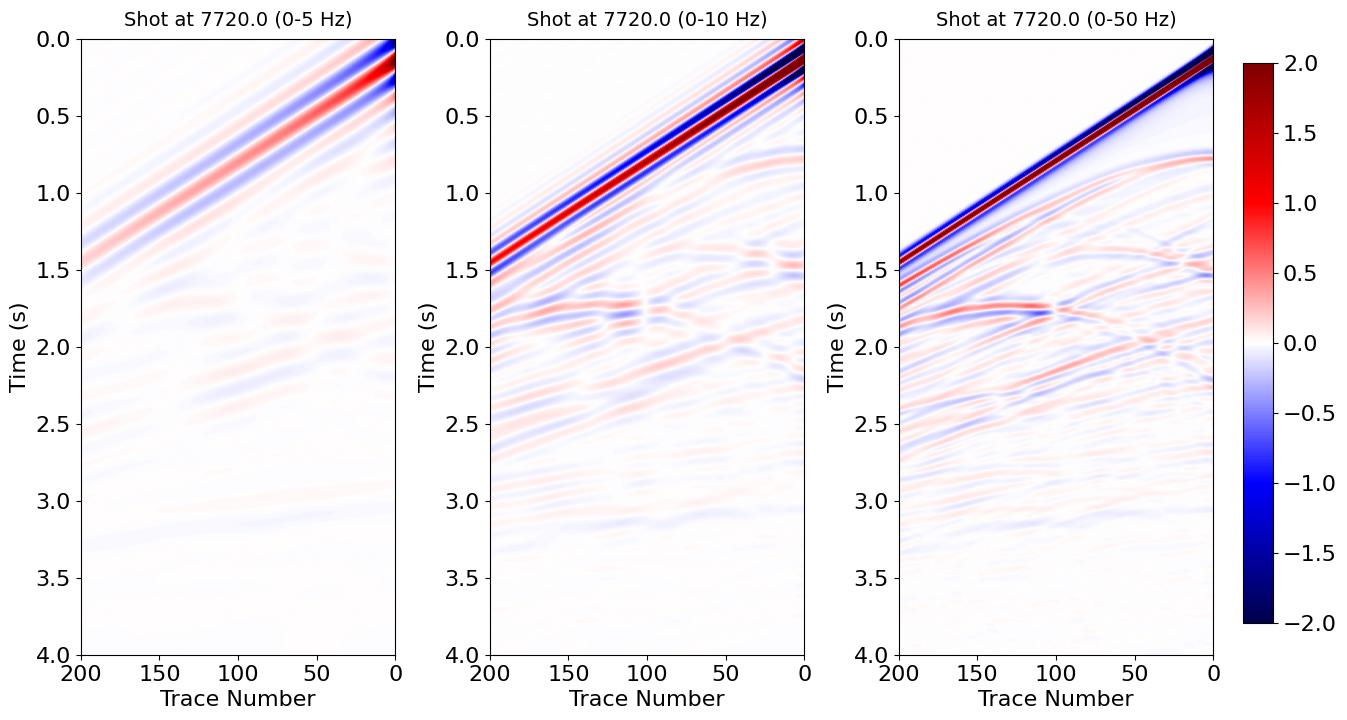

In [15]:
plot_shotrecord_cust(dobs1[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-5 Hz)',
                     dobs2[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-10 Hz)',
                     dobs3[19].data, f'Shot at {geometry1[19].src_positions[0][0].item()} (0-50 Hz)',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)


In [17]:
# Run born fwi
# Create initial guess model for inversion by smoothing the true model

model_up = torch.tensor(model0.vp.data[nbl:-nbl, nbl:-nbl]).T
model_tr = torch.tensor(model1.vp.data[nbl:-nbl, nbl:-nbl]).T
scat = torch.zeros_like(model_up)

# Store to GPU
device = 'cuda'
model_up = model_up.clone().to(device)
model_tr = model_tr.clone().to(device)
model_up.requires_grad = True
model_tr.requires_grad = True
scat.requires_grad = True

msk = torch.ones_like(torch.Tensor(model_up))
msk[:50] = 0
#msk = msk.to(device)

depth = torch.tensor(list(range(0, 351))*1100).reshape(1100, 351).T /351
fwi_itr = 30
first_ep, eps = 50, 5

# Set up params
device = 'cuda'
network = AttentionR2UNet(n_channels=2, n_classes=1, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_mse = torch.nn.MSELoss()
loss_mae = torch.nn.L1Loss()

# Set up FWI loss function
def loss_fn_fwi(model_true, model_init, geoms, n_workers, clients, d_true, freq, nfilt):

    # Set initial and true model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_init = get_model(model_init.detach().cpu().numpy(), shape, spacing, origin)
    

    loss, grad = grad_multi_shots(model_true, model_init, geoms, n_workers, clients, d_true, freq, nfilt)    
    client.restart(wait_for_workers=False)
    
    return loss, torch.tensor(grad).T

def born_fn_fwi(model_true, model_back, model_scat, geoms, n_workers, client, freq, nfilt):

    # Set initial, true, and scat model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_back = get_model(model_back.detach().cpu().numpy(), shape, spacing, origin)
    
    _, dm1 = born_multi_shots(model_true, model_back, model_scat, geoms, n_workers, client, freq, nfilt)
    client.restart(wait_for_workers=False)
    
    return torch.tensor(dm1).T
    

### Scale 1 (0-5 Hz)

In [ ]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt1.copy()
freq = 0.005
nfilt = 9

# Set up storage for scale 1
seis_loss1 = []
vp_mse1, vp_mae1, ssim1 = [], [], []
net_loss1 = []

fpath = 'model_progress/marm_gn_attention_r2unet_ms/scale1'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse1.append(mseloss)
vp_mae1.append(maeloss)
ssim1.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f'Iteration {itr+1}: data loss = {loss}')
    seis_loss1.append(loss)

    # Normalize by the maximum of the each gradient and mask the shallow part
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max

    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss1.append(running_loss/len(dataloader))

        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')

    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse1[-1] <= vp_mse1[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse1.append(mseloss)
    vp_mae1.append(maeloss)
    ssim1.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse1)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae1)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim1)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss1)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss1)

    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up1 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

In [19]:
print(f'Running Duration for scale 1 (0-5Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 1 (0-5Hz): 3.32 hrs


### Scale 2 (0-10 Hz)

In [ ]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt2.copy()
freq = 0.01
nfilt = 9

# Set up storage for scale 1
seis_loss2 = []
vp_mse2, vp_mae2, ssim2 = [], [], []
net_loss2  = []

fpath = 'model_progress/marm_gn_attention_r2unet_ms/scale2'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse2.append(mseloss)
vp_mae2.append(maeloss)
ssim2.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f'Iteration {itr+1}: data loss = {loss}')
    seis_loss2.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    #if itr == 0:
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    #if itr == 0:
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max
    
    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss2.append(running_loss/len(dataloader))
    
        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse2[-1] <= vp_mse2[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse2.append(mseloss)
    vp_mae2.append(maeloss)
    ssim2.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse2)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae2)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim2)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss2)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss2)
        
    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up2 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

In [21]:
print(f'Running Duration for scale 2 (0-10Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 2 (0-10Hz): 3.30 hrs


### Scale 3 (0-20 Hz)

In [ ]:
# Set up parameters
nbl = model1.nbl
geoms = geometry1.copy()
d_true = dobsfilt3.copy()
freq = 0.05
nfilt = 9

# Set up storage for scale 3
seis_loss3 = []
vp_mse3, vp_mae3, ssim3 = [], [], []
net_loss3 = []

fpath = 'model_progress/marm_gn_attention_r2unet_ms/scale3'

strt = time.time()

# compute the first velocity difference after update model
mseloss = loss_mse(model_up, model_tr).item()
maeloss = loss_mae(model_up, model_tr).item()
ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
vp_mse3.append(mseloss)
vp_mae3.append(maeloss)
ssim3.append(ssimval)

for itr in range(fwi_itr):
    
    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, n_workers, client, d_true, freq, nfilt)
    print(f'Iteration {itr+1}: data loss = {loss}')
    seis_loss3.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    #if itr == 0:
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)
    
    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client, freq, nfilt)
    
    # Normalize by the maximum and mask the shallow part
    #if itr == 0:
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max
    
    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_mse(dm_pred, y1)
            running_loss += loss_.item()
            
            loss_.backward()
            optimizer.step()
    
        net_loss3.append(running_loss/len(dataloader))
    
        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)
    
        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = torch.clip((model_up-dm), minv, maxv)
    elif itr != 0 and vp_mse3[-1] <= vp_mse3[-2]:
        model_up = torch.clip((model_up-dm), minv, maxv)
    
    # compute the velocity difference after update model
    mseloss = loss_mse(model_up, model_tr).item()
    maeloss = loss_mae(model_up, model_tr).item()
    ssimval = ssim(model_up.detach().cpu().numpy(), model_tr.detach().cpu().numpy(), data_range=model_up.detach().cpu().numpy().max() - model_up.detach().cpu().numpy().min())
    print(f'Iteration {itr+1}: MSE loss = {mseloss}')
    print(f'Iteration {itr+1}: MAE loss = {maeloss}')
    print(f'Iteration {itr+1}: SSIM Value = {ssimval}')
    vp_mse3.append(mseloss)
    vp_mae3.append(maeloss)
    ssim3.append(ssimval)

    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())

    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/vp_mse_monitor.txt', vp_mse3)
        np.savetxt(f'{fpath}/vp_mae_monitor.txt', vp_mae3)
        np.savetxt(f'{fpath}/ssim_monitor.txt', ssim3)
        np.savetxt(f'{fpath}/seis_loss_monitor.txt', seis_loss3)
        np.savetxt(f'{fpath}/net_loss_monitor.txt', net_loss3)
        
    del dataloader
    gc.collect()
    torch.cuda.empty_cache()

model_up3 = model_up.clone().to(device)

fnsh = time.time()
dur = fnsh-strt

In [23]:
print(f'Running Duration for scale 3 (0-50Hz): {((dur)/3600):.2f} hrs')

Running Duration for scale 3 (0-50Hz): 3.34 hrs


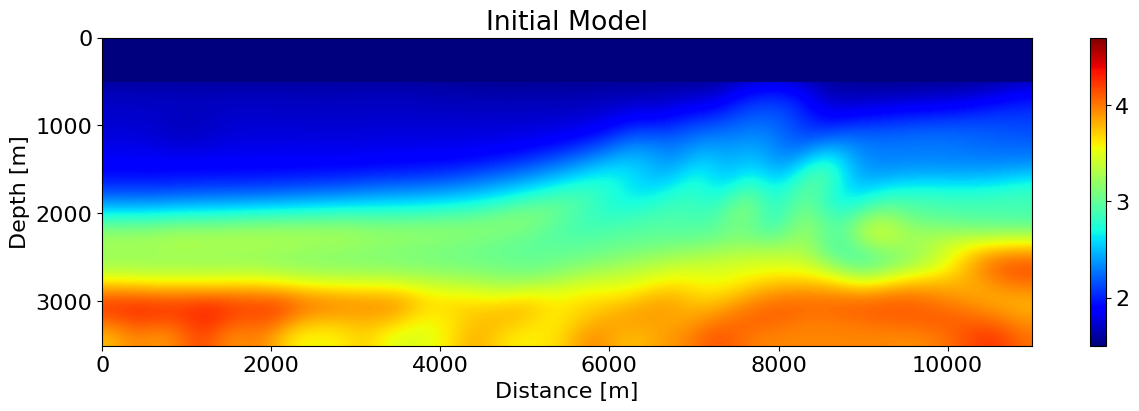

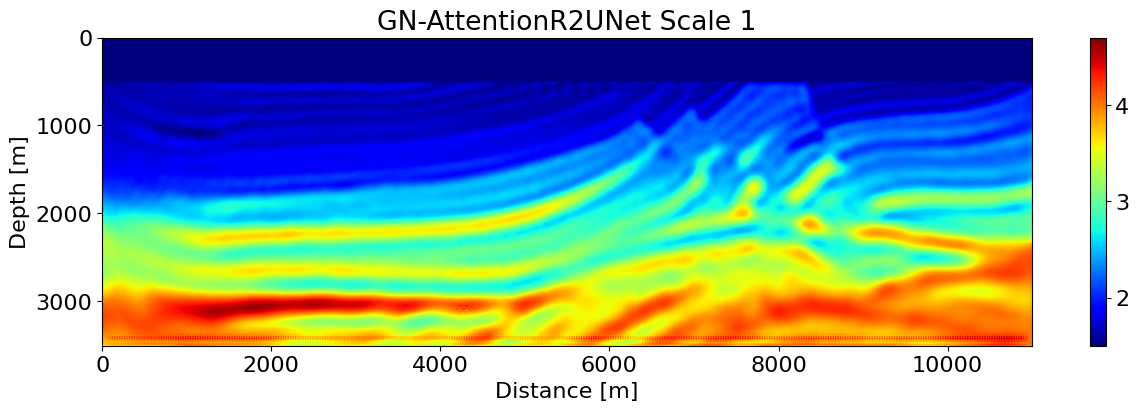

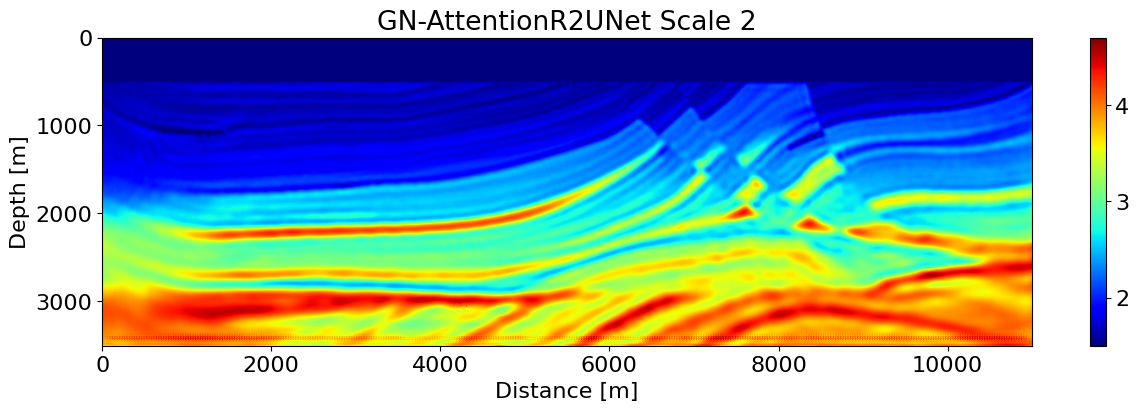

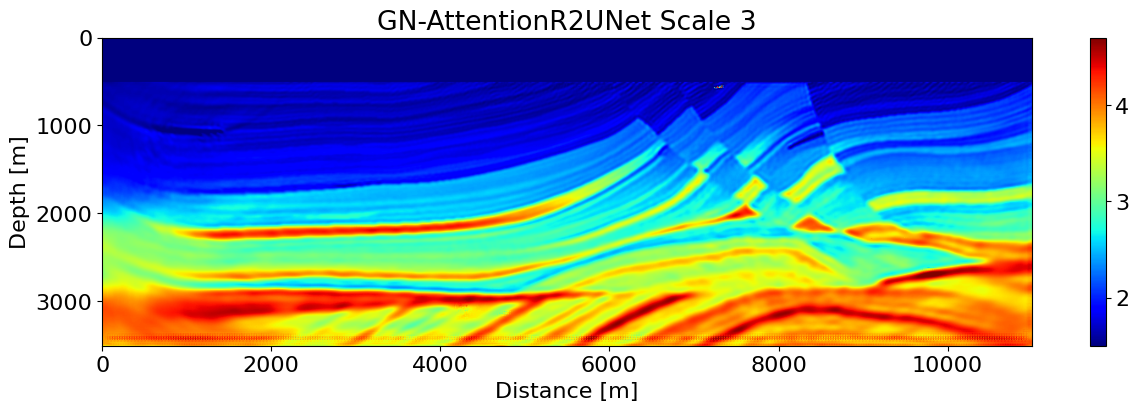

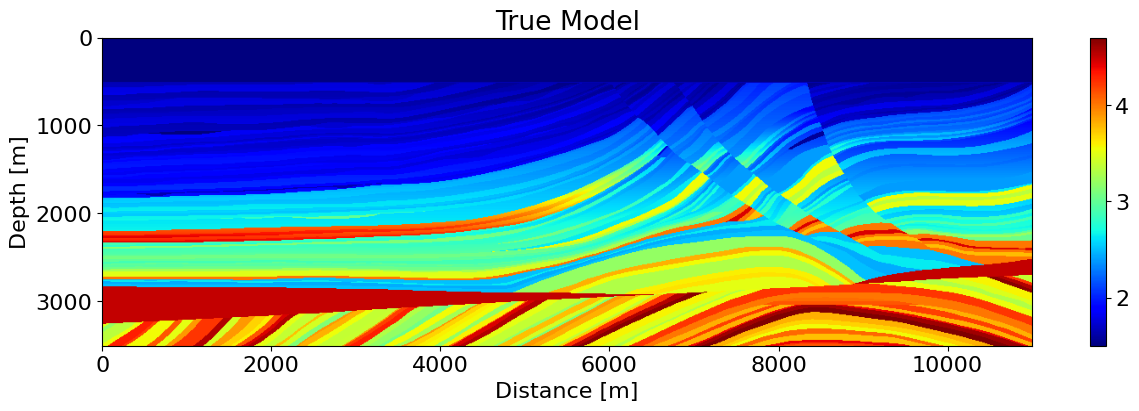

In [24]:
vp1 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale1/model_monitor.txt')
vp2 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale2/model_monitor.txt')
vp3 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale3/model_monitor.txt')

vp1 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale1/model_monitor.txt')
vp2 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale2/model_monitor.txt')
vp3 = np.loadtxt(f'model_progress/marm_gn_attention_r2unet_ms/scale3/model_monitor.txt')

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

vm = 0.1
shrink=1
figsize=(15,4)
extent = (0, 11000, 3510, 0)

plt.figure(figsize=figsize)
plt.title('Initial Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(init[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-AttentionR2UNet Scale 1')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp1, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-AttentionR2UNet Scale 2')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp2, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('GN-AttentionR2UNet Scale 3')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(vp3, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.figure(figsize=figsize)
plt.title('True Model')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
cb = plt.imshow(v[:1100].T, aspect='auto', cmap='jet', vmin=1.5, vmax=4.7, extent=extent)
plt.colorbar(cb, shrink=shrink)

plt.show()